In [1]:
import os

import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.io import ascii

from scipy import ndimage
from scipy import spatial
from scipy import interpolate


import numpy as np

import pandas as pd

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
from astropy import units as u
from astropy.cosmology import z_at_value

from astropy.coordinates import SkyCoord, match_coordinates_sky

In [2]:
nsig = 4
names = ['U0', 'U1', 'V0', 'V1', 'value_U', 'value_V', 'type', 'boundary']
segs = pd.read_csv(f'./disperse/input.survey_ascii.NDnet_s{nsig:d}.up.NDskl.rmB.rmO.BRK.S010.a.segs', header = None, comment ='#', delimiter = ' ', names = names)

names = ['X0', 'X1', 'value', 'type', 'pair_id', 'boundary']
crits = pd.read_csv(f'./disperse/input.survey_ascii.NDnet_s{nsig:d}.up.NDskl.rmB.rmO.BRK.S010.a.crits', header = None, comment ='#', delimiter = ' ', names = names)

minima, saddle_1, saddle_2, nodes = [crits[crits.type == i][['X0','X1']].values for i in np.arange(4)]


U = segs[['U0', 'U1']].values
V = segs[['V0', 'V1']].values

segs_mid = (U + V) / 2

d_node_tree = spatial.cKDTree(nodes)
d_saddle_1_tree = spatial.cKDTree(saddle_1)
d_saddle_2_tree = spatial.cKDTree(saddle_2)
d_minima_tree = spatial.cKDTree(minima)
d_skel_tree = spatial.cKDTree(segs_mid)

LSBG candidates

In [3]:
path = './bottrell/stz855_supplemental_files/Stripe82_DeepMorphologies_TXT/'
tbl_fn = ascii.read(path + 'sdss_s82_morph_gr_fn.txt')

def bulge(r, Sig_e, r_e, n):
    
    k = 1.9992 * n - 0.3271
    func = Sig_e * np.exp(-k * ( (r/r_e)**(1/n) - 1 ) )
    
    return func

def disk(r, Sig_0, r_d):
    
    func = Sig_0 * np.exp(- r/r_d)
    
    return func

radii = np.arange(0.01, 20, 0.01) #arcsec

In [4]:
ras = tbl_fn['ra']
ra_mask = tbl_fn['ra'] > 300
ras[ra_mask] = ras[ra_mask] - 360

decs = tbl_fn['decl']

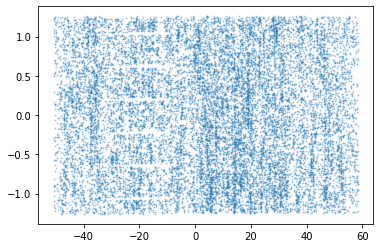

In [5]:
plt.scatter(ras, decs, s = 1, alpha = .3)

In [6]:
coords = np.array([ras, decs]).T
coords

array([[ 12.603   ,   0.880015],
       [-41.282   ,  -0.977773],
       [-24.126   ,   0.275031],
       ...,
       [ 41.6005  ,   0.193539],
       [ 17.0147  ,   1.08358 ],
       [ 26.9959  ,  -0.702274]])

In [7]:
mu0_fn = []
for idx in range(len(tbl_fn)):
    # bulge to total ratio
    btt = tbl_fn['bt_r'][idx]

    #flux per area
    flux_bulge_arb = bulge(r = radii, Sig_e = 10, r_e = tbl_fn['re'][idx], n = tbl_fn['n'][idx])
    flux_disk_arb = disk(r = radii, Sig_0 = 10, r_d = tbl_fn['rd'][idx])
    flux_disk_arb *= sum(flux_bulge_arb)/sum(flux_disk_arb) * (1 - btt) / btt

    petro_r50 = tbl_fn['petroR50_g'][idx]
    petro_r50_idx = int(petro_r50 // 0.01)

    #flux within r50 to SB
    flux_bulge_arb_r50 = flux_bulge_arb[:petro_r50_idx]
    flux_disk_arb_r50 = flux_disk_arb[:petro_r50_idx]
    flux_total_arb_r50 = flux_bulge_arb_r50 + flux_disk_arb_r50

    flux_avg_r50 = [flux_total_arb_r50[ii] * 2 * np.pi * 0.01**2 * (ii+1) for ii in range(len(flux_total_arb_r50))] 
    flux_avg_r50 = np.sum(flux_avg_r50) / (np.pi * petro_r50**2)

    # SB in R50 catalog / smae derived
    factor = 10**((tbl_fn['mu50_g'][idx] - 30) / -2.5) / flux_avg_r50
    flux_bulge_corr = flux_bulge_arb * factor * btt
    flux_disk_corr = flux_disk_arb * factor * (1 - btt)
    flux_total = flux_bulge_corr + flux_disk_corr
    # flux_corr = 10**((sb_arb - 30) / -2.5) * factor
    sb_bulge_corr = -2.5 * np.log10(flux_bulge_corr) + 30
    sb_disk_corr = -2.5 * np.log10(flux_disk_corr) + 30
    sb_total = -2.5 * np.log10(flux_total) + 30
    
    mu0 = sb_disk_corr[0]
    mu0_fn.append(mu0)

mu0_fn = np.array(mu0_fn)

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply


In [8]:
sf_mask = mu0_fn > 23
inc_mask = tbl_fn['incd'] <= 30
zmask = (tbl_fn['z'] > 0.05) & (tbl_fn['z'] < 0.15)

lsb_mask = sf_mask & inc_mask & zmask
hsb_mask = ~sf_mask & inc_mask & zmask

In [9]:
sum(lsb_mask), sum(hsb_mask)

(929, 1097)

In [10]:
d_node_subhalo = d_node_tree.query(coords)[0]
d_saddle_1_subhalo = d_saddle_1_tree.query(coords)[0]
d_saddle_2_subhalo = d_saddle_2_tree.query(coords)[0]
d_minima_subhalo = d_minima_tree.query(coords)[0]
d_skel_subhalo = d_skel_tree.query(coords)[0]

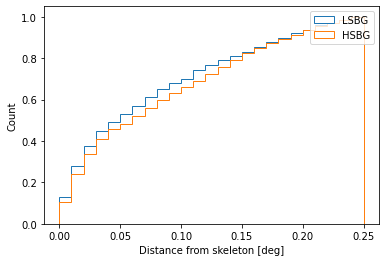

In [11]:
plt.hist(d_skel_subhalo[lsb_mask], histtype = 'step', bins = np.arange(0, 0.26, 0.01), label = 'LSBG', cumulative=True, density = True)
plt.hist(d_skel_subhalo[hsb_mask], histtype = 'step', bins = np.arange(0, 0.26, 0.01), label = 'HSBG', cumulative=True, density = True)

plt.xlabel('Distance from skeleton [deg]')
plt.ylabel('Count')

plt.legend()

plt.savefig('./figs/distance_from_skeleton.png')

In [14]:
cls = Table.read('geach11.fit')
mask = (cls['z'] < 0.2)

cls = cls[mask]

ra_cls = cls['RAJ2000']
mask_ra = (ra_cls > 200)
ra_cls[mask_ra] = ra_cls[mask_ra] - 360

dec_cls = cls['DEJ2000']
z_cls = cls['z']

In [ ]:
flag = [True] + [(segs['V0'][i-1] != segs['U0'][i]) & (segs['V1'][i-1] != segs['U1'][i]) for i in range(1, len(segs))]
start_idxs = np.where(flag)[0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


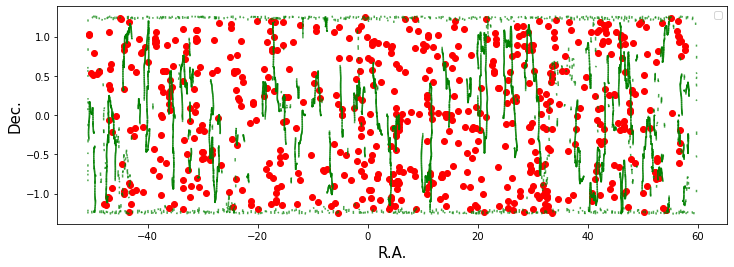

In [15]:
fig, ax = plt.subplots(figsize = (12, 4))
for ii in start_idxs:
    
    ax.plot([segs['U0'][ii], segs['V0'][ii]], [segs['U1'][ii], segs['V1'][ii]], color = 'green', alpha = .7)

# ax.scatter(ras[lsb_mask], decs[lsb_mask], marker = '*', color = 'red', label = 'LSBG')
# ax.scatter(ras[hsb_mask], decs[hsb_mask], marker = 's', color = 'blue', label = 'HSBG')
    
ax.scatter(ra_cls, dec_cls, color = 'r')

    
ax.legend()
ax.set_xlabel('R.A.', fontsize = 15)
ax.set_ylabel('Dec.', fontsize = 15)
fig.savefig('./figs/filament_disperse.png')

1. ObjID SDSS photometric identification number 
- [skyVersion=1,rerun,run,camcol,field,obj].
2. GLXID GALEX photometric identification number
3. plate SDSS spectroscopic plate number
4. MJD SDSS spectroscopic plate date
5. fiber ID SDSS spectroscopic fiber identification number
6. RA deg Right Ascension from SDSS
7. Decl. deg Declination from SDSS
8. z Redshift from SDSS
9. 2r Reduced goodnes-of-fit value for the SED fitting
10. logM⇤ M Stellar mass
11. (logM⇤) M Error of the stellar mass
12. log SFRSED Myr-1 UV/optical (SED) star formation rate
13. (log SFRSED) Myr-1 Error of the SFR
14. AFUV mag Dust attenuation in rest-frame FUV
15. (AFUV) mag Error of dust attenuation in FUV
16. AB mag Dust attenuation in rest-frame B
17. (AB) mag Error of dust attenuation in B
18. AV mag Dust attenuation in rest-frame V
19. (AV ) mag Error of dust attenuation in V
20. flag_sed SED fitting flag (0 = OK, 1 = broad-line spectrum, 2 = 2r > 30, 5 = missing SDSS photometry)
21. UV survey 1 = GSWLC-A, 2 = GSWLC-M, 3 = GSWLC-D
22. flag_uv UV (GALEX) flag (0 = no UV; 1 = FUV only; 2 = NUV only; 3 = both)
23. flag_midir Mid-IR (unWISE) flag (0 = no mid-IR, 1 = LIR based on 12 µm, 2 = LIR based on 22 µm; 5 = LIR corrected for mid-IR AGN emission)
24. flag_mgs 0 = not in SDSS Main Galaxy Sample (MGS), 1 = in MGS

In [ ]:
gswlc = Table.read('./data/GSWLC-A2.dat', format = 'ascii.no_header')

In [214]:
tbl_ra = tbl_fn['ra']
ramask = tbl_ra < 0
tbl_ra[ramask] = 360 + tbl_ra[ramask]
tbl_dec = tbl_fn['decl']

In [215]:
cat1 = SkyCoord(ra = tbl_ra * u.degree, dec = tbl_dec * u.degree)
cat2 = SkyCoord(ra = gswlc['col6'] * u.degree, dec = gswlc['col7'] * u.degree)

In [216]:
idx, d2d, d3d = match_coordinates_sky(cat1, cat2)
max_sep = 1.0 * u.arcsec

sep_mask = d2d < max_sep

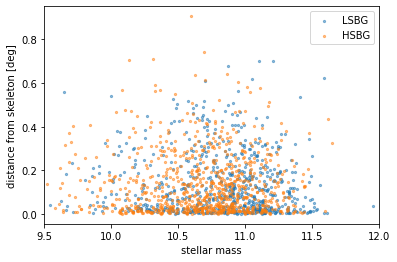

In [218]:
plt.scatter(gswlc[idx]['col10'][lsb_mask & sep_mask], d_skel_subhalo[lsb_mask& sep_mask], s = 5, alpha = .5, label = 'LSBG')
plt.scatter(gswlc[idx]['col10'][hsb_mask& sep_mask], d_skel_subhalo[hsb_mask& sep_mask], s = 5, alpha = .5, label = 'HSBG')

plt.legend()
plt.xlim(9.5, 12)
# plt.ylim(0, 0.1)

plt.xlabel('stellar mass')
plt.ylabel('distance from skeleton [deg]')

plt.savefig('./figs/sm_distance.png')

In [219]:
dist_hsbg = []
dist_lsbg = []
for sm in np.arange(10, 11.5, 0.5):
    
    samp = gswlc[idx]['col10'][lsb_mask & sep_mask]
    smask = (samp >= sm) & (samp < sm + 0.5)    
    dist_lsbg.append(np.median(d_skel_subhalo[lsb_mask& sep_mask][smask]))
    
    samp = gswlc[idx]['col10'][hsb_mask & sep_mask]
    smask = (samp >= sm) & (samp < sm + 0.5)    
    dist_hsbg.append(np.median(d_skel_subhalo[hsb_mask& sep_mask][smask]))
    

In [221]:
# plt.scatter(np.arange(10, 11.5, 0.5), dist_hsbg)
# plt.scatter(np.arange(10, 11.5, 0.5), dist_lsbg)

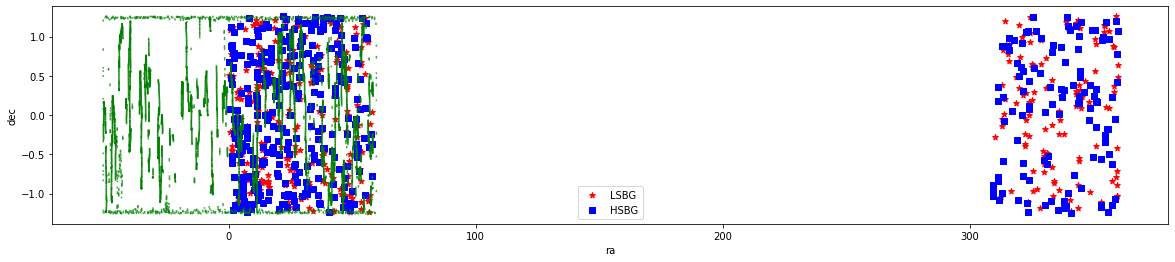

In [184]:
flag = [True] + [(segs['V0'][i-1] != segs['U0'][i]) & (segs['V1'][i-1] != segs['U1'][i]) for i in range(1, len(segs))]
start_idxs = np.where(flag)[0]

fig, ax = plt.subplots(figsize = (20, 4))
for ii in start_idxs:
    
    ax.plot([segs['U0'][ii], segs['V0'][ii]], [segs['U1'][ii], segs['V1'][ii]], color = 'green', alpha = .7)

ax.scatter(ras[lsb_mask & sep_mask & (d_skel_subhalo < 0.1)], decs[lsb_mask& sep_mask&(d_skel_subhalo < 0.1)], marker = '*', color = 'red', label = 'LSBG')
ax.scatter(ras[hsb_mask& sep_mask & (d_skel_subhalo < 0.1)], decs[hsb_mask& sep_mask & (d_skel_subhalo < 0.1)], marker = 's', color = 'blue', label = 'HSBG')
    
ax.legend()
ax.set_xlabel('ra')
ax.set_ylabel('dec')
fig.savefig('./figs/density_field.png')

In [223]:
2 * 3600 * 2

14400